In [1]:
!pip install langgraph langchain_openai langchain-google-genai langchain langchain_tavily tavily-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.5/438.5 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 128.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 20.6 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.60
    Uninstalling langchain-core-0.3.60:
      Successfully uninstalled langchain-core-0.3.60
  Attempting uninstal

In [3]:
import os
from google.colab import userdata

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

In [4]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List, Sequence
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from langchain.chat_models import init_chat_model

In [5]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [6]:
model = init_chat_model("gpt-4.1-nano", model_provider="openai")

In [7]:
PLAN_PROMPT = """
You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections.
"""

WRITER_PROMPT = """
You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed:

------

{content}
"""

REFLECTION_PROMPT = """
You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc.
"""

RESEARCH_PLAN_PROMPT = """
You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max.
"""

RESEARCH_CRITIQUE_PROMPT = """
You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max.
"""


In [8]:
from pydantic import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [9]:
from tavily import TavilyClient
from langchain_tavily import TavilySearch
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [10]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    current_content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            current_content.append(r['content'])
    return {"content": current_content}

def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content,
        "revision_number": state.get("revision_number", 1) + 1
    }


def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [11]:
builder = StateGraph(AgentState)
builder.add_node("planner", plan_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_critique", research_critique_node)

builder.set_entry_point("planner")
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")
builder.add_conditional_edges(
    "generate",
    should_continue,
    {END: END, "reflect": "reflect"}
)

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")
# builder.add_edge("research_plan", END) # Debug

graph = builder.compile()

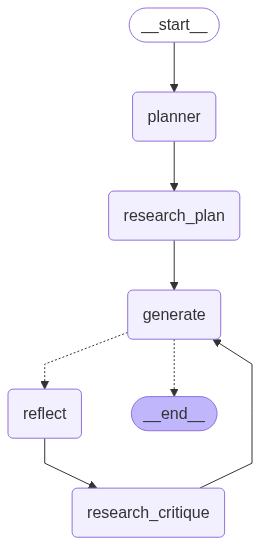

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
config = {
    "task": "Write an essay to introduce AI agent with RAG",
    "max_revisions": 2,
    "revision_number": 1,
    "content": [],
    "plan": "",
    "draft": "",
    "critique": ""
}

graph_state = graph.invoke(config)
print("\nFinal Draft:")
print(graph_state['draft'])


Final Draft:
Artificial intelligence has continually evolved from simple rule-based systems to sophisticated models capable of understanding and generating human-like responses. Among the latest innovations in this field are AI agents—autonomous systems designed to perform tasks, answer queries, and make decisions on behalf of humans. As these agents become more advanced, they increasingly rely on new approaches to improve their knowledge and responsiveness. One such groundbreaking development is Retrieval-Augmented Generation (RAG), a technique that combines the strength of information retrieval systems with generative language models to create more intelligent and contextually aware AI agents. This essay aims to introduce AI agents empowered by RAG technology and explore their transformative potential across various domains.

AI agents are autonomous entities that operate within specific environments to accomplish tasks such as answering questions, assisting users, or automating pro